In [49]:
library(forecast)
library(tseries)
library(lmtest)
library(Hmisc)

In [94]:
data <- read.csv("data.tsv", sep = "\t")
data <- data[,1:2]
names(data)[1] <- "Date"
names(data)[2] <- "Value"
data$Date <- as.Date(as.yearmon(data$Date, format = "%Y-%m"))

In [104]:
xname <- "Real monthly wage"

In [97]:
tSeries <- ts(data = data$Value, start = as.numeric(c(format(data$Date[1], "%Y"), format(data$Date[1], "%m"))),
              freq = 12)

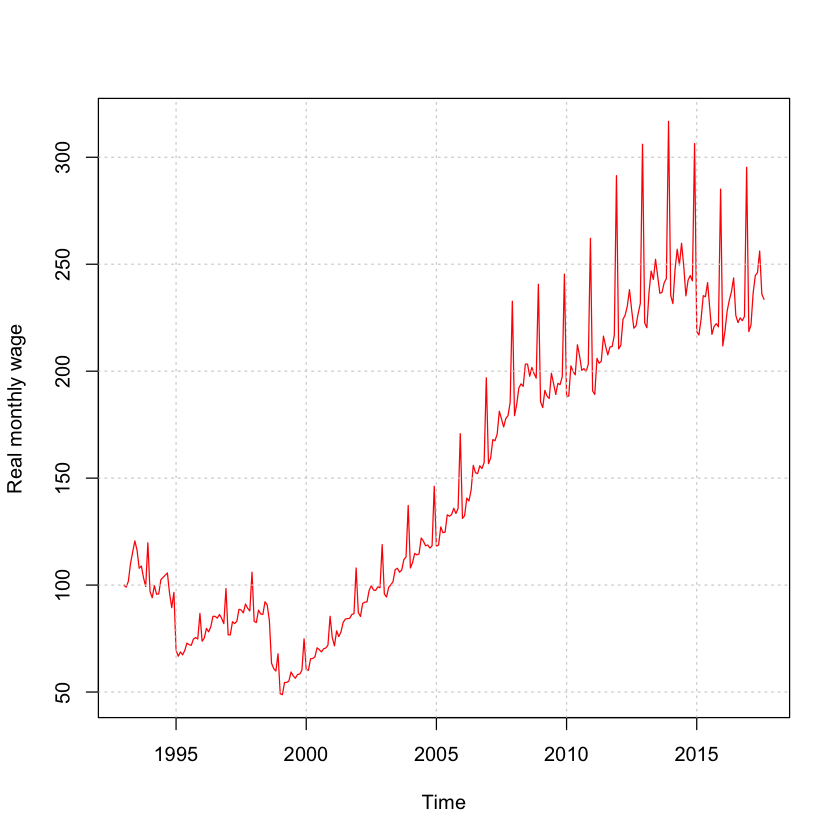

In [105]:
plot(tSeries, type="l", ylab=xname, col="red")
grid()

In [136]:
trainSeries <- window(tSeries, end=c(2015,12))
testSeries  <- window(tSeries, start=c(2016,1))
D <- 24

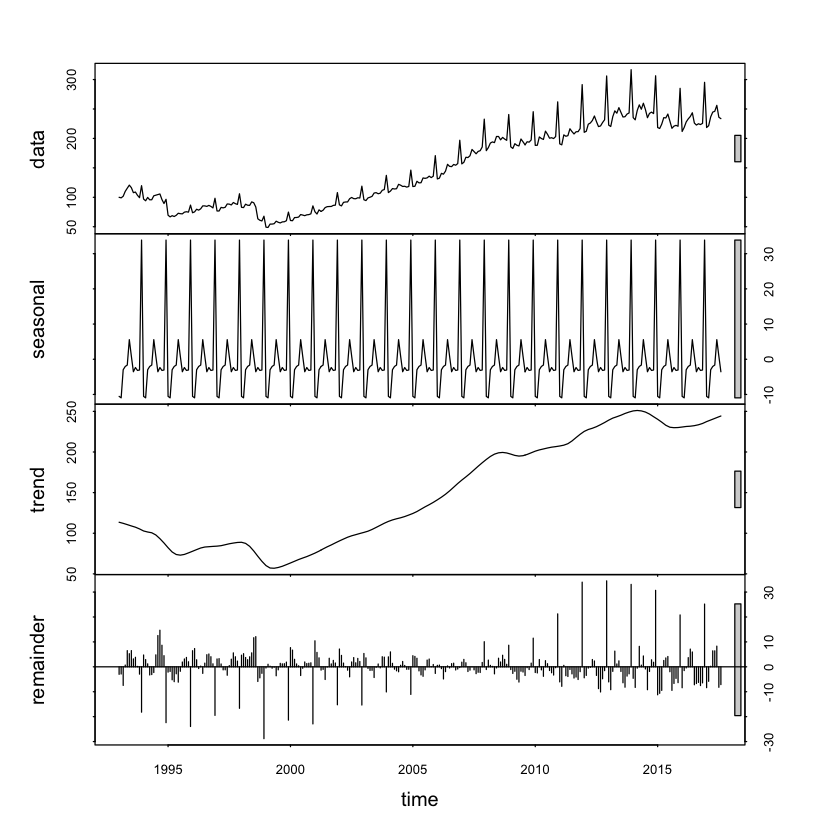

In [107]:
plot(stl(tSeries, s.window="periodic"))

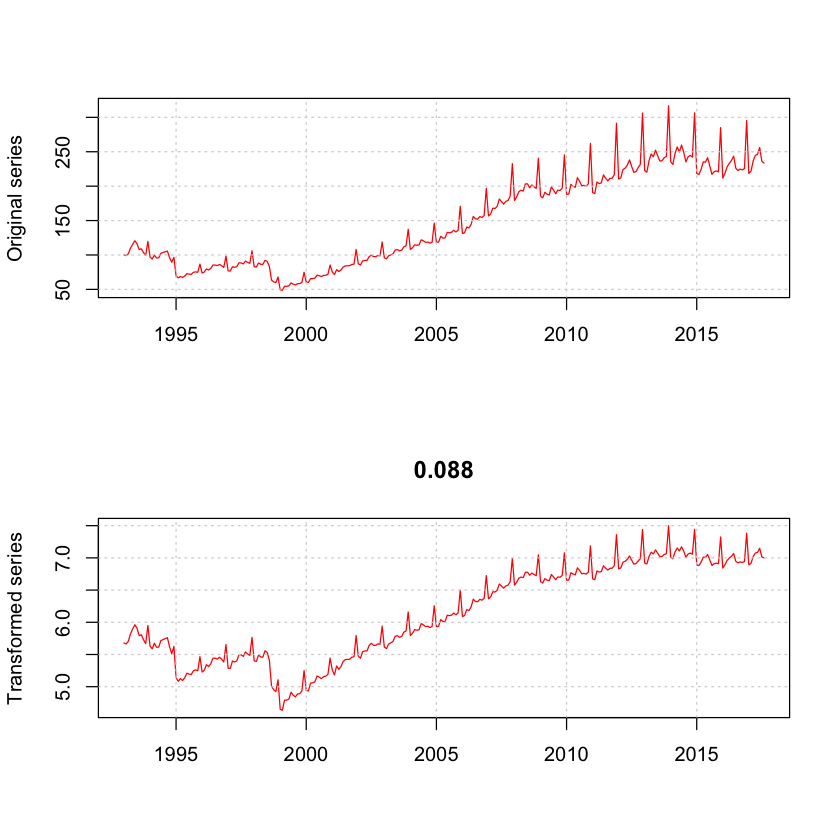

In [110]:
par(mfrow=c(2,1))
plot(tSeries, ylab="Original series", xlab="", col="red")
grid()

LambdaOpt <- BoxCox.lambda(tSeries)
plot(BoxCox(tSeries, LambdaOpt), ylab="Transformed series", xlab="", col="red")
title(main=toString(round(LambdaOpt, 3)))
grid()

In [119]:
fit.auto <- auto.arima(tSeries, lambda=LambdaOpt)
fit.auto

Series: tSeries 
ARIMA(1,1,1)(2,1,2)[12] 
Box Cox transformation: lambda= 0.08800602 

Coefficients:
         ar1      ma1     sar1    sar2    sma1     sma2
      0.7396  -0.5959  -0.7157  0.0272  0.0433  -0.4476
s.e.  0.1351   0.1597   0.3658  0.1019  0.3612   0.2170

sigma^2 estimated as 0.002354:  log likelihood=454.48
AIC=-894.95   AICc=-894.55   BIC=-869.44

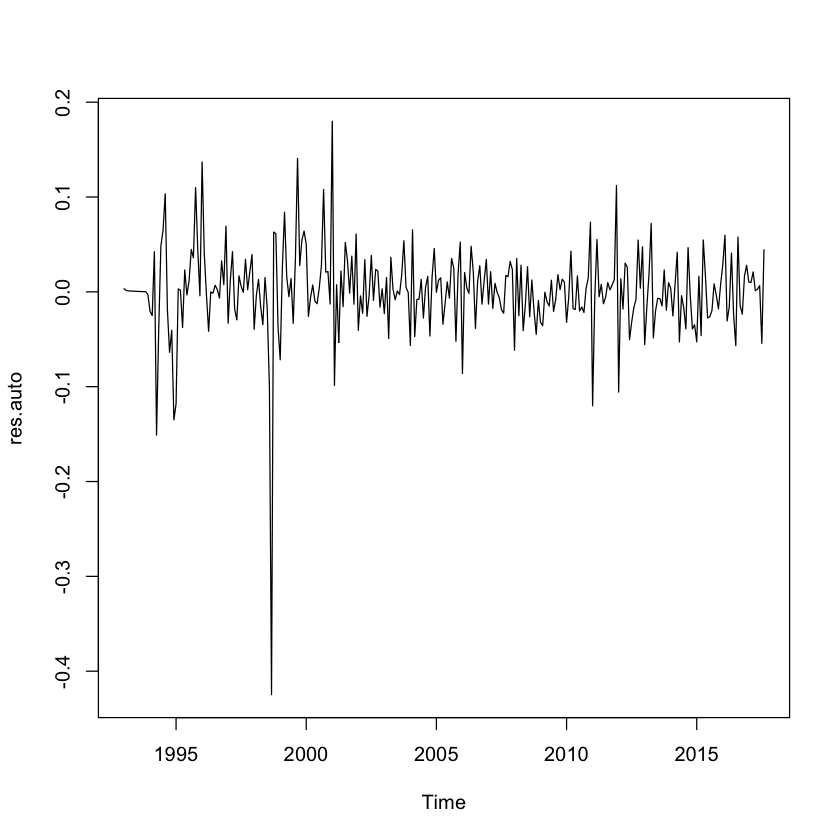

In [120]:
res.auto <- residuals(fit.auto)
plot(res.auto)

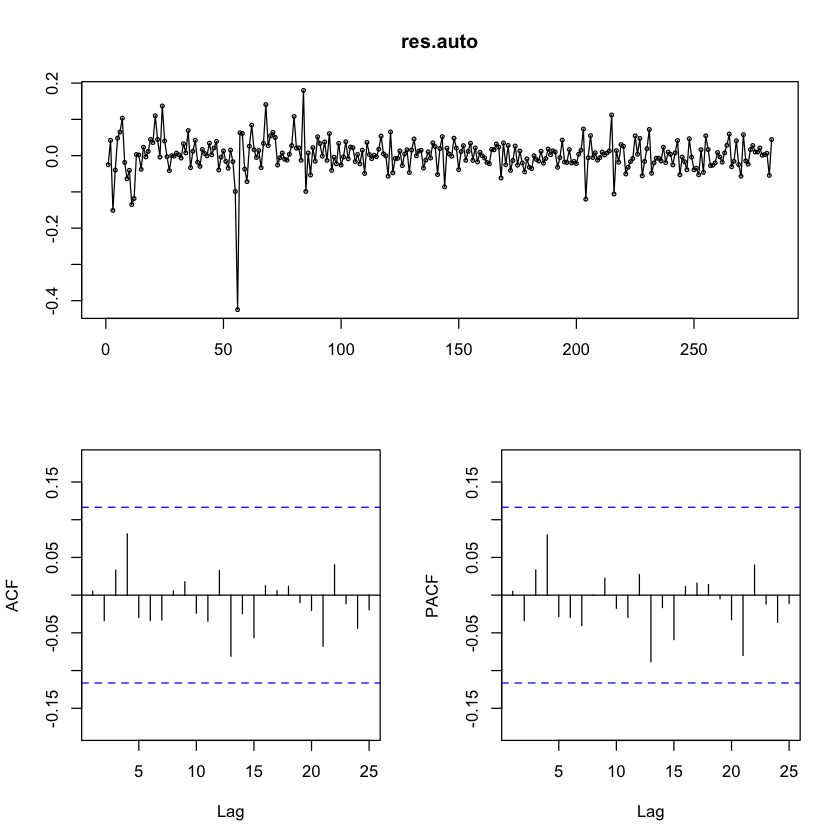

In [122]:
res.auto <- res.auto[-c(1:13)]
tsdisplay(res.auto)

In [126]:
p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res.auto, lag=i, type = "Ljung-Box")$p.value
}

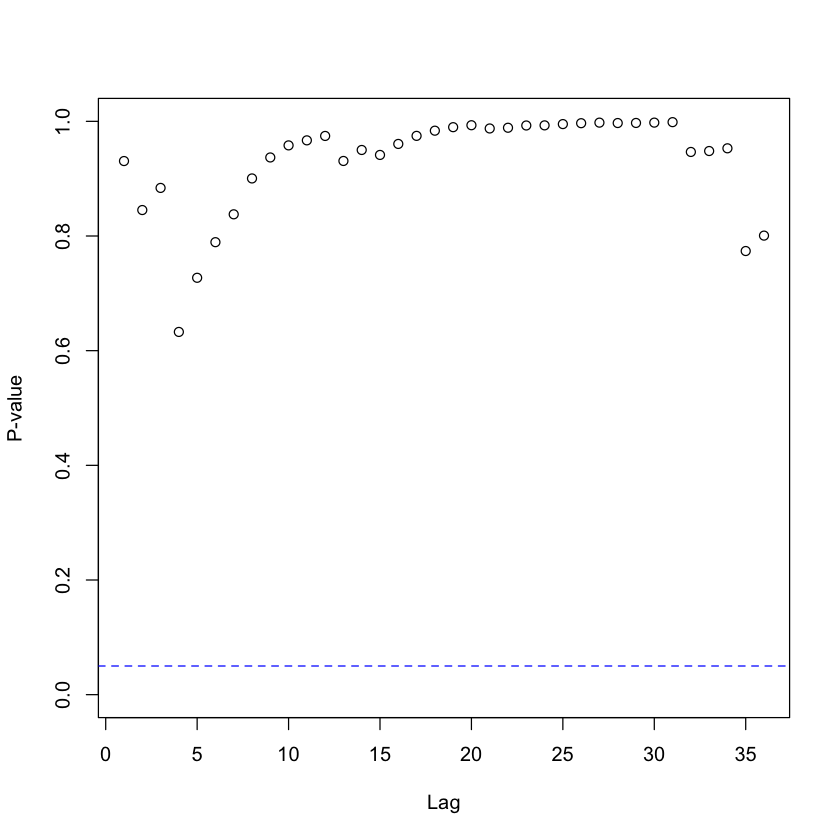

In [127]:
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

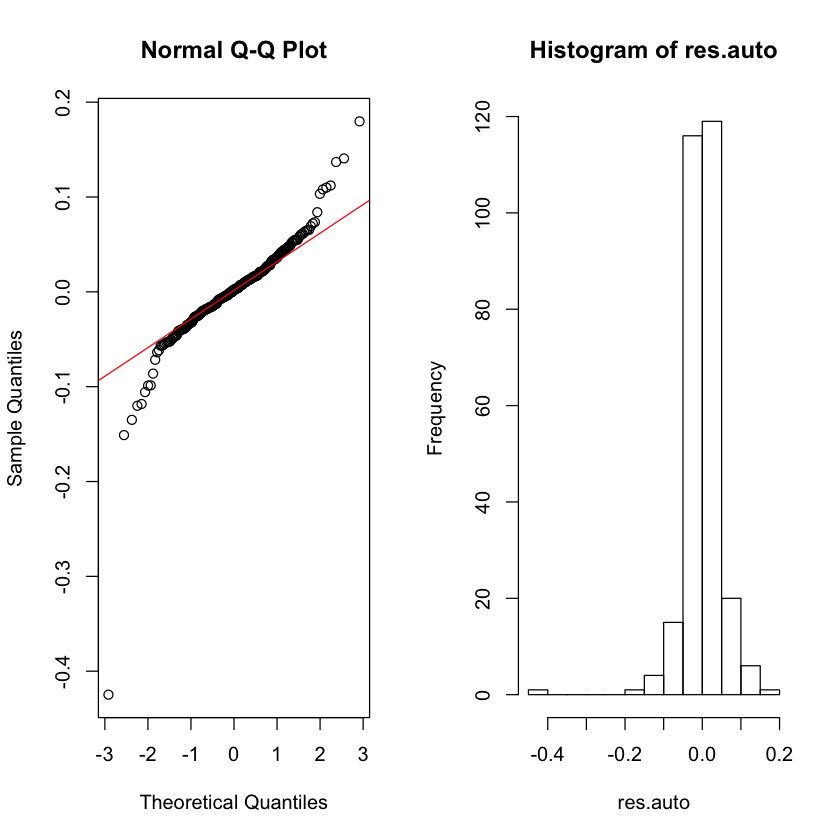

In [129]:
par(mfrow=c(1,2))
qqnorm(res.auto)
qqline(res.auto, col="red")
hist(res.auto)

In [131]:
shapiro.test(res.auto)$p.value
wilcox.test(res.auto)$p.value
kpss.test(res.auto)$p.value

[1] 6.343054e-17

[1] 0.3664499

Warning message in kpss.test(res.auto):
“p-value greater than printed p-value”

[1] 0.1

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.07193325,3.832109,2.545853,-0.01343871,1.971086,0.181575,-0.1367121,NA
Test set,15.22564757,17.030579,15.225648,6.42529719,6.425297,1.085921,0.6659089,0.7451245


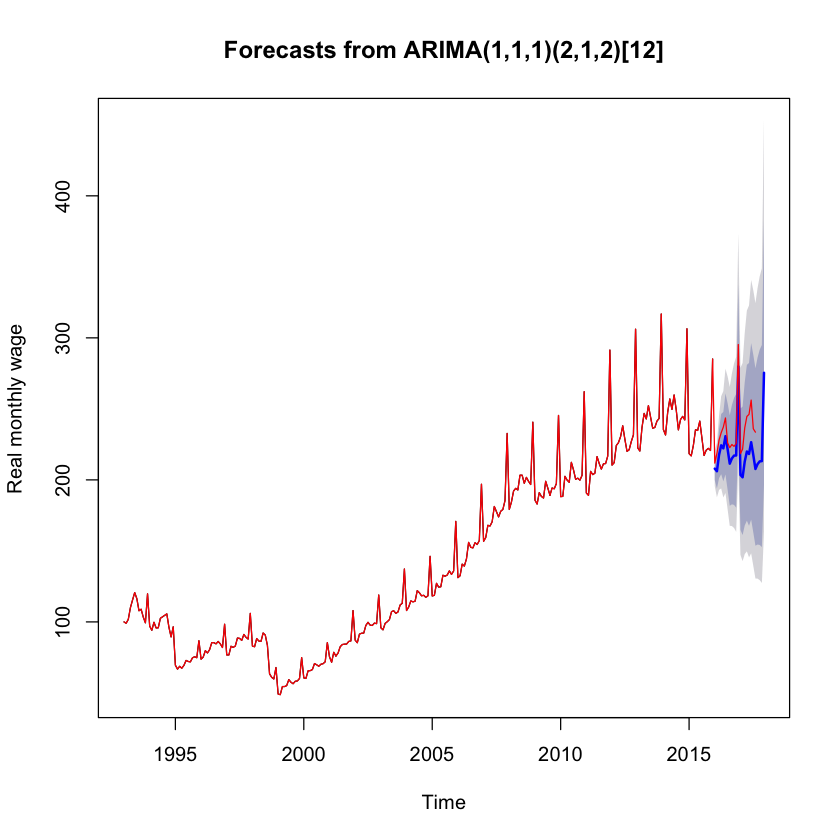

In [139]:
fitShort <- Arima(trainSeries, order=c(1,1,1), seasonal=c(2,1,2), lambda=LambdaOpt)
fc       <- forecast(fitShort, h=D)
accuracy(fc, testSeries)
plot(forecast(fitShort, h=D), ylab=xname, xlab="Time")
lines(tSeries, col="red")

In [143]:
kpss.test(BoxCox(tSeries, LambdaOpt))$p.value

Warning message in kpss.test(BoxCox(tSeries, LambdaOpt)):
“p-value smaller than printed p-value”

[1] 0.01

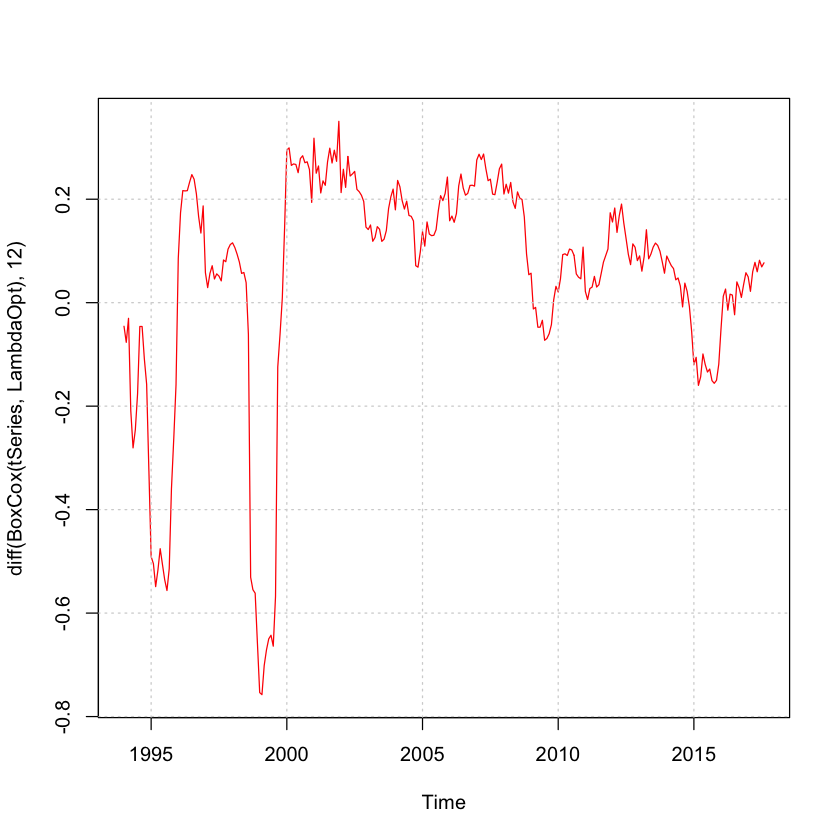

In [141]:
plot(diff(BoxCox(tSeries, LambdaOpt), 12), type="l", col="red")
grid()

In [147]:
kpss.test(diff(BoxCox(tSeries, LambdaOpt), 12))$p.value

[1] 0.01057417

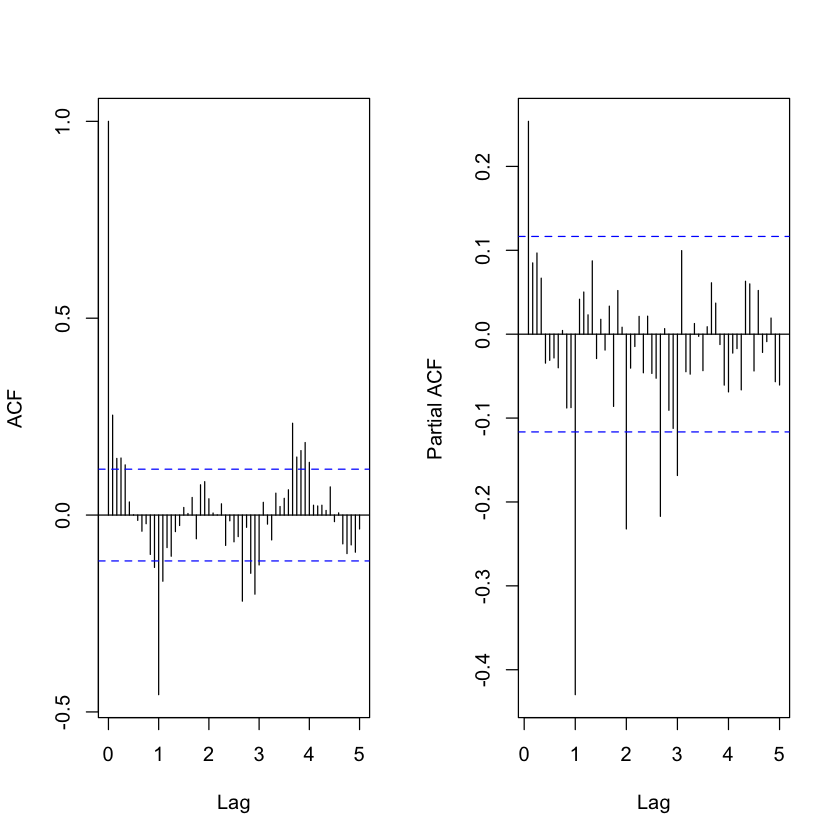

In [148]:
par(mfrow=c(1,2))
acf(diff(diff(BoxCox(tSeries, LambdaOpt), 12), 1), lag.max=5*12, main="")
pacf(diff(diff(BoxCox(tSeries, LambdaOpt), 12), 1), lag.max=5*12, main="")

In [149]:
fit <- auto.arima(tSeries, d=1, D=1, max.p=5, max.q=1, max.P = 0, max.Q = 2, max.order = 10, lambda=LambdaOpt, stepwise=F)
fit

Series: tSeries 
ARIMA(3,1,0)(0,1,1)[12] 
Box Cox transformation: lambda= 0.08800602 

Coefficients:
         ar1     ar2     ar3     sma1
      0.1611  0.0580  0.0949  -0.6465
s.e.  0.0598  0.0602  0.0605   0.0454

sigma^2 estimated as 0.00235:  log likelihood=453.83
AIC=-897.67   AICc=-897.45   BIC=-879.44

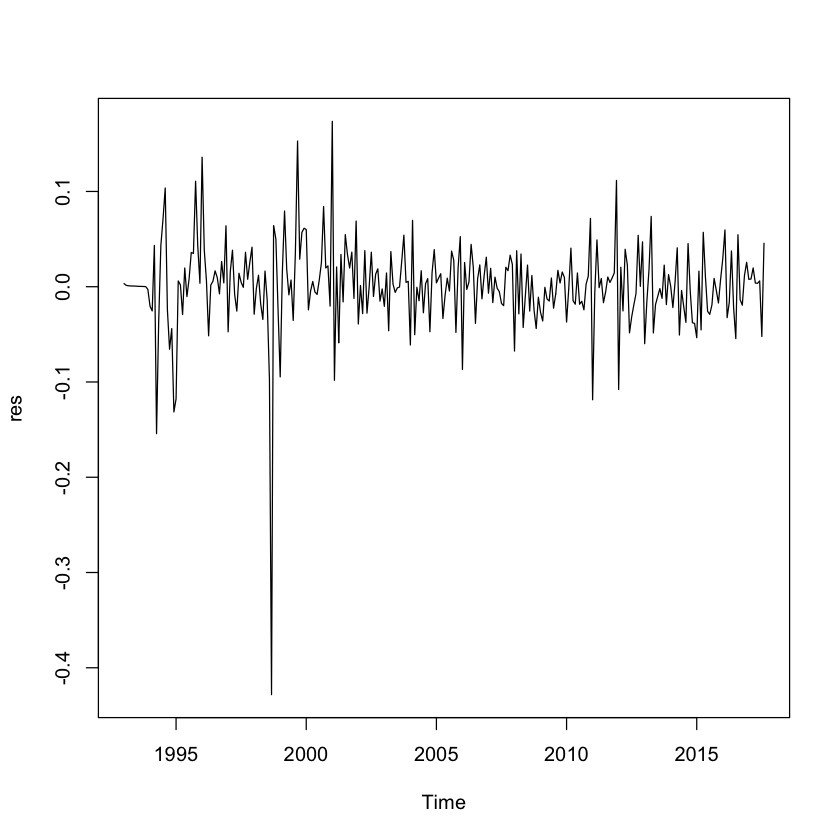

In [150]:
res <- residuals(fit)
plot(res)

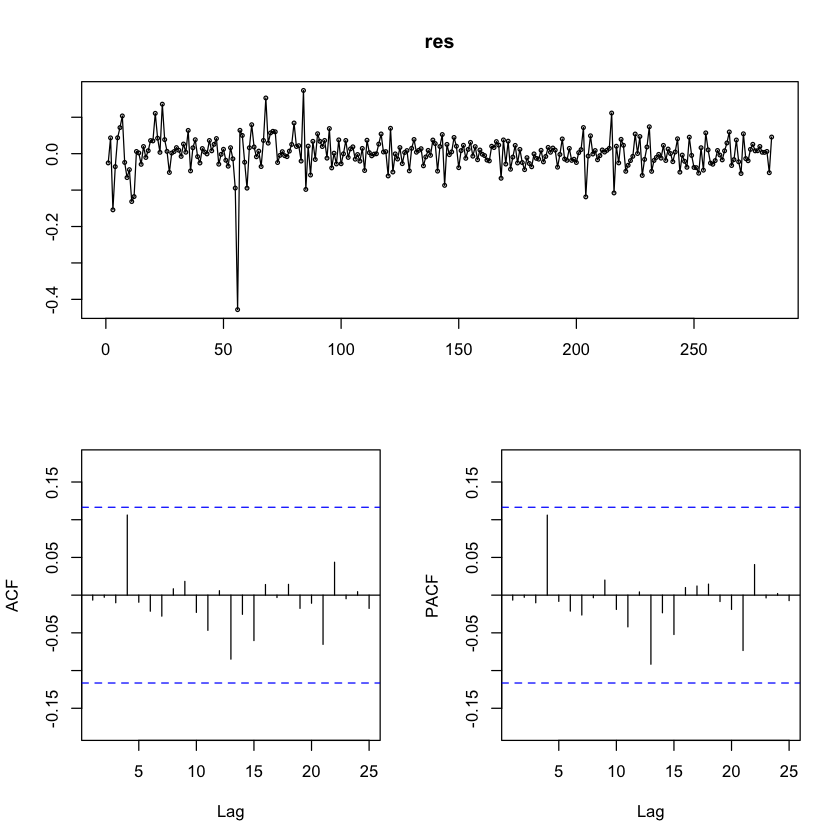

In [151]:
res <- res[-c(1:13)]
tsdisplay(res)

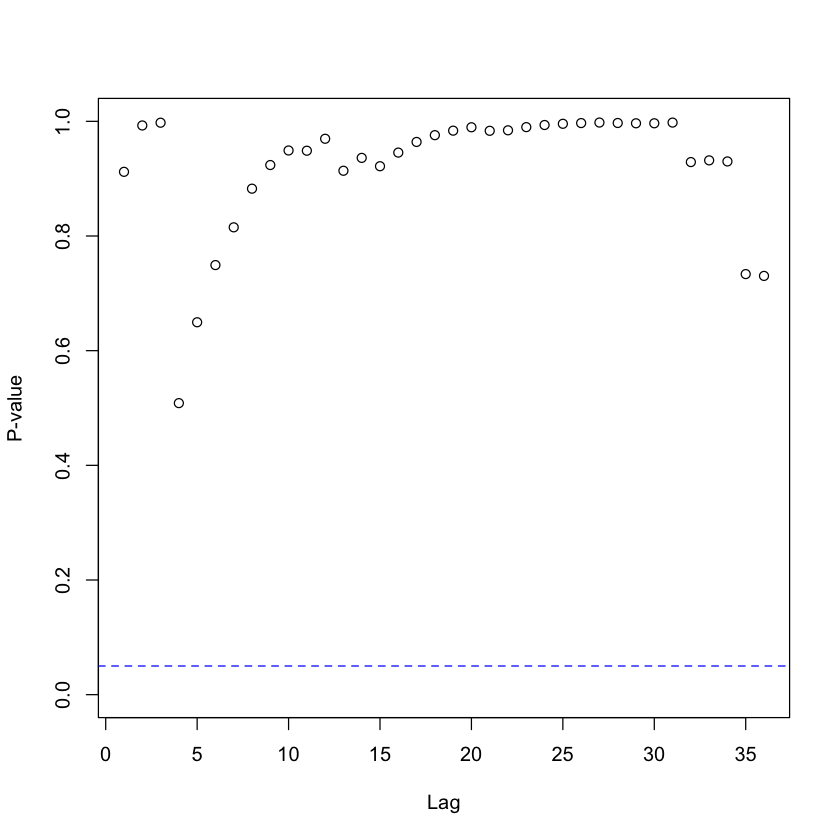

In [152]:
p <- rep(0, 1, frequency(tSeries)*3)
for (i in 1:length(p)){
  p[i] <- Box.test(res, lag=i, type = "Ljung-Box")$p.value
}
plot(p, xlab="Lag", ylab="P-value", ylim=c(0,1))
abline(h = 0.05, lty = 2, col = "blue")

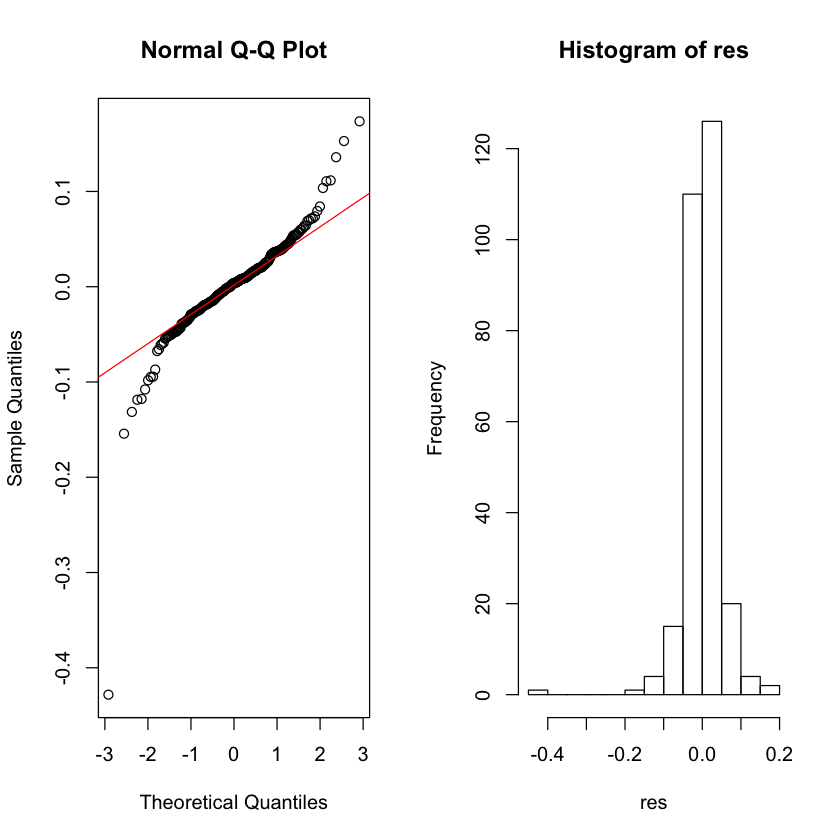

In [153]:
par(mfrow=c(1,2))
qqnorm(res)
qqline(res, col="red")
hist(res)

In [154]:
shapiro.test(res)$p.value
wilcox.test(res)$p.value
kpss.test(res)$p.value

[1] 4.614106e-17

[1] 0.2774695

Warning message in kpss.test(res):
“p-value greater than printed p-value”

[1] 0.1

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.06702276,3.840327,2.541343,-0.007023565,1.971246,0.1812533,-0.1452584,NA
Test set,13.80180793,15.431423,13.801808,5.825917293,5.825917,0.9843706,0.6311357,0.6758536


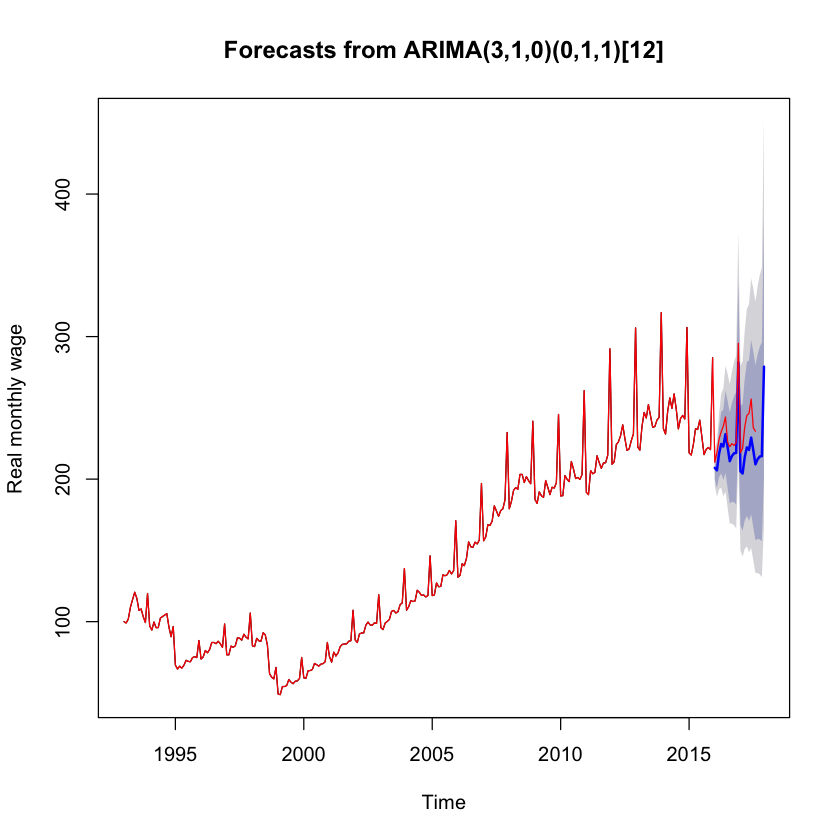

In [155]:
fitShort <- Arima(trainSeries, order=c(3,1,0), seasonal=c(0,1,1), lambda=LambdaOpt)
fc       <- forecast(fitShort, h=D)
accuracy(fc, testSeries)
plot(forecast(fitShort, h=D), ylab=xname, xlab="Time")
lines(tSeries, col="red")

In [156]:
res      <- (tSeries - fitted(fit))[-c(1:13)]
res.auto <- (tSeries - fitted(fit.auto))[-c(1:13)]


	Diebold-Mariano Test

data:  resres.auto
DM = -0.11962, Forecast horizon = 1, Loss function power = 2, p-value =
0.9049
alternative hypothesis: two.sided


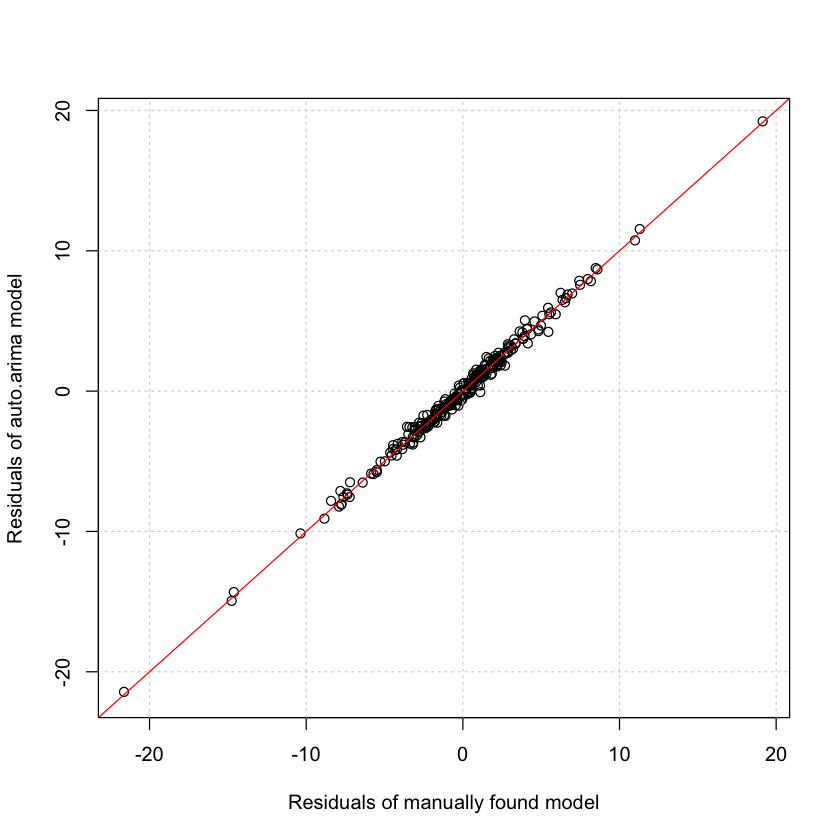

In [157]:
plot(res, res.auto, xlim=c(min(res, res.auto), max(res, res.auto)), ylim=c(min(res, res.auto), max(res, res.auto)), 
     xlab = "Residuals of manually found model", ylab="Residuals of auto.arima model")
grid()
lines(c(min(res, res.auto), max(res, res.auto))*2, c(min(res, res.auto), max(res, res.auto))*2, col="red")

dm.test(res, res.auto)

Warning message in InvBoxCox(pred$pred, lambda, biasadj, var(residuals(object), :
“biasadj information not found, defaulting to FALSE.”

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Sep 2017       237.5632 231.2360 244.2192 223.9110 249.3641
Oct 2017       238.1899 227.9528 249.2171 218.4920 257.8681
Nov 2017       239.7073 226.0664 254.7468 214.4527 266.3824
Dec 2017       310.4231 289.2884 334.2215 271.2895 351.2828
Jan 2018       229.0811 210.0702 250.9481 193.3163 265.1461
Feb 2018       231.2374 209.5526 256.7287 188.5622 272.2282
Mar 2018       244.4394 219.5720 273.6797 193.5539 292.1566
Apr 2018       251.8407 223.6609 285.1987 195.0000 305.0181
May 2018       252.5147 221.6443 288.4051 191.4770 310.3767
Jun 2018       261.7925 227.3006 301.2737 194.6627 325.2090
Jul 2018       245.9740 211.9211 285.4371 180.3201 309.4990
Aug 2018       239.7220 204.0625 281.0322 174.3063 305.1725
Sep 2018       243.3528 205.2941 288.9349 174.1847 314.0268
Oct 2018       244.1594 203.0647 292.9900 171.2053 320.2109
Nov 2018       245.3513 201.7933 297.9848 168.5638 328.6442
Dec 2018       317.4532 258.2798 388.327

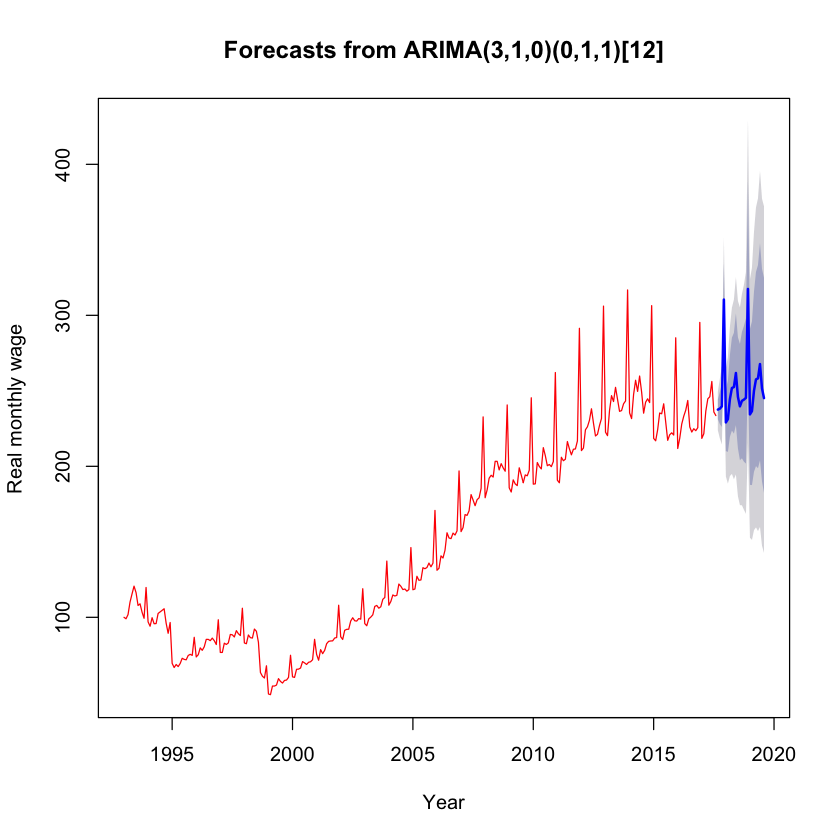

In [158]:
fl <- forecast(fit, h=D, lambda=LambdaOpt,bootstrap = T)
print(fl)
plot(fl, ylab=xname, xlab="Year", col="red")